# Image Recognition using Tensorflow Hub

In [2]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
import numpy as np

tf.__version__

W0316 17:58:47.869760 140560046204800 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.13.1'

In [3]:
data_path = tf.keras.utils.get_file('flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [4]:
#Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
#Takes the path to a directory & generates batches of augmented data.
images = image_generator.flow_from_directory(str(data_path))

Found 3670 images belonging to 5 classes.


In [5]:
for image_batch, label_batch in images:
  print("image batch is:", image_batch.shape)
  print("label batch is:", label_batch.shape)
  break

image batch is: (32, 256, 256, 3)
label batch is: (32, 5)


In [0]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

In [7]:
def classifier(x):
  classi = hub.Module(classifier_url)
  return classi(x)

image_size = hub.get_expected_image_size(hub.Module(classifier_url))

Instructions for updating:
Colocations handled automatically by placer.


W0316 17:59:17.710102 140560046204800 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [8]:
model = tf.keras.Sequential()
model.add(layers.Lambda(classifier, input_shape = image_size+[3]))
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0316 17:59:32.911105 140560046204800 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [9]:
#set output size to match with what is expected by the module
images = image_generator.flow_from_directory(str(data_path), target_size=image_size)
for image_batch, label_batch in images:
  print("image batch is:", image_batch.shape)
  print("label batch is:", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
image batch is: (32, 224, 224, 3)
label batch is: (32, 5)


In [0]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

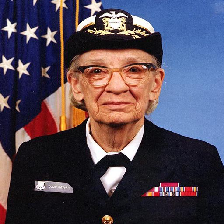

In [14]:
import PIL.Image as Image
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(image_size)
grace_hopper

In [15]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [16]:
#passing the image to the model
result = model.predict(grace_hopper[np.newaxis, ...]) #newaxis = increase by dimension, here make a row vector
result.shape

(1, 1001)

In [17]:
predicted_class = np.argmax(result[0], axis=-1) #top class ID can be found with argmax
predicted_class

653

Decode predictions

In [18]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


'military uniform'

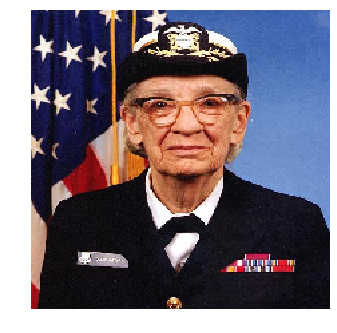

In [19]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
#_ = plt.title("Prediction: " + predicted_class_name)
predicted_class_name

In [20]:
result_batch = model.predict(image_batch)
predicted = np.argmax(result_batch, axis=-1)
labels_batch = imagenet_labels[predicted]
labels_batch

array(['bee', 'tractor', 'daisy', 'daisy', 'vase', 'plow',
       'sulphur butterfly', 'paper towel', 'feather boa', 'rapeseed',
       'daisy', 'daisy', 'hip', 'hip', 'hip', 'bee', 'cardoon',
       "jack-o'-lantern", 'daisy', 'daisy', 'pot', 'ant', 'daisy',
       'daisy', 'daisy', 'matchstick', 'mushroom', 'tarantula', 'bee',
       'cardoon', 'daisy', 'daisy'], dtype='<U30')

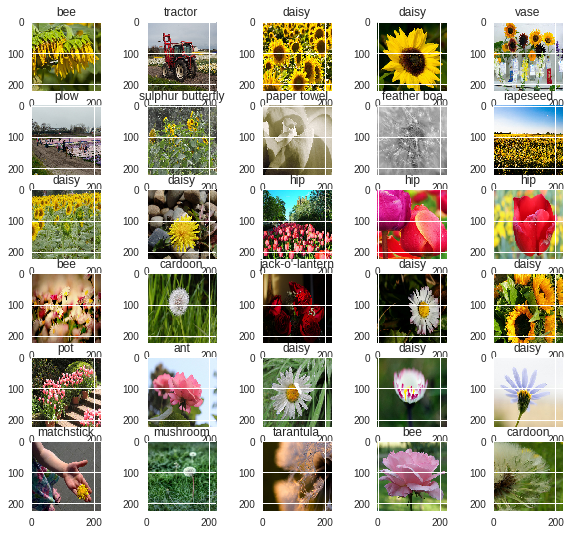

In [21]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])

The above predictions are wrong. 

# **Simple Transfer Learning**

considering that these are not the classes the model was trained for. Using tfhub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

In [0]:
def feature_extractor(x):
  features = hub.Module(feature_extractor_url)
  return features(x)

image_size = hub.get_expected_image_size(hub.Module(feature_extractor_url))
#image_size

In [28]:
#set output size to match with what is expected by the module
images = image_generator.flow_from_directory(str(data_path), target_size=image_size)
for image_batch, label_batch in images:
  print("image batch is:", image_batch.shape)
  print("label batch is:", label_batch.shape)
  break
  

Found 3670 images belonging to 5 classes.
image batch is: (32, 224, 224, 3)
label batch is: (32, 5)


In [0]:
feature_extractor_layer = layers.Lambda(classifier, input_shape = image_size+[3])
feature_extractor_layer.trainable = False # freeze variables in the feature extraction layer so that only variables in new classifier layer get changed

In [37]:
feature_model = tf.keras.Sequential()
feature_model.add(feature_extractor_layer)
feature_model.add(layers.Dense(images.num_classes, activation = 'softmax')) # adding a new layer

feature_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0316 18:21:13.519114 140560046204800 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 1001)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 5010      
Total params: 5,010
Trainable params: 5,010
Non-trainable params: 0
_________________________________________________________________


In [0]:
init = tf.global_variables_initializer()
sess.run(init)

In [40]:
result = feature_model.predict(image_batch)
result.shape

(32, 5)

In [0]:
feature_model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])



In [57]:
steps_per_epoch = images.batch_size
batch_stats = CollectBatchStats()
feature_model.fit((item for item in images), epochs=3, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/3
32/32 [==============================] - 53s 2s/step - loss: 0.5693 - acc: 0.8057
Epoch 2/3
32/32 [==============================] - 51s 2s/step - loss: 0.4906 - acc: 0.8213
Epoch 3/3
32/32 [==============================] - 51s 2s/step - loss: 0.4077 - acc: 0.8639


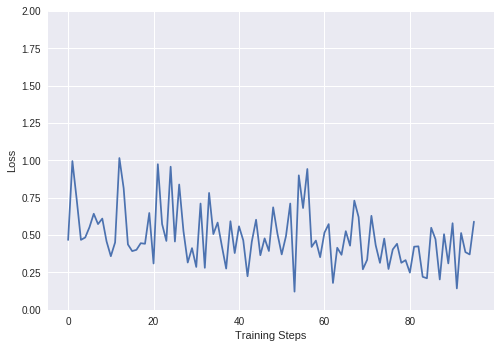

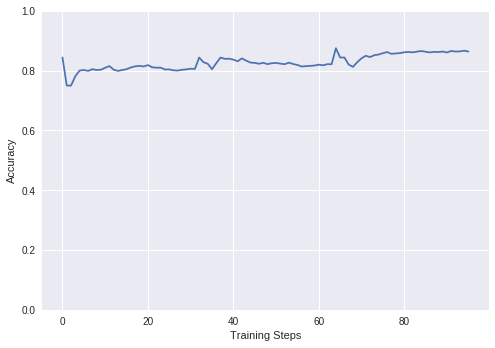

In [58]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

In [60]:
#get ordered list of class names
label_names = sorted(images.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [61]:
#run the image batch through the model and convert the indices to class names.
results = feature_model.predict(image_batch)

labels_batch = label_names[np.argmax(results, axis=-1)]
labels_batch

array(['Dandelion', 'Sunflowers', 'Roses', 'Tulips', 'Sunflowers',
       'Dandelion', 'Tulips', 'Tulips', 'Daisy', 'Dandelion', 'Dandelion',
       'Daisy', 'Tulips', 'Tulips', 'Sunflowers', 'Dandelion', 'Tulips',
       'Sunflowers', 'Dandelion', 'Roses', 'Dandelion', 'Sunflowers',
       'Sunflowers', 'Daisy', 'Dandelion', 'Tulips', 'Sunflowers',
       'Roses', 'Tulips', 'Roses', 'Tulips', 'Sunflowers'], dtype='<U10')

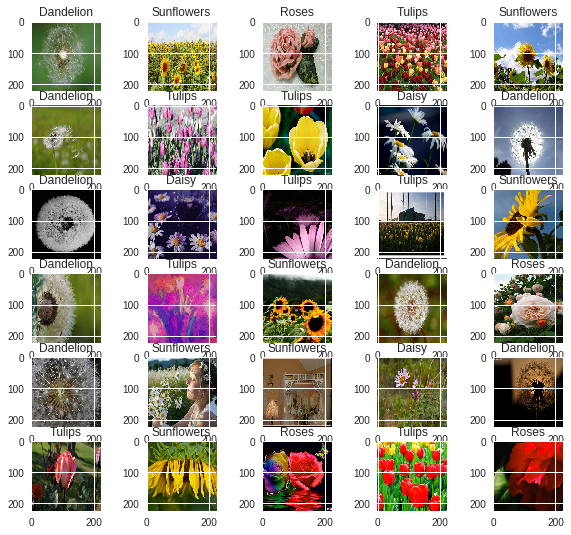

In [63]:
#plotting the predictions

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])

### The above is an almost accurate prediction of the images.